# Big Data y Machine Learning (UBA) 2025
## Tutorial 12 - Clasificacion II: Comparación & Curvas ROC 

**Objetivo:** Utilizar análisis de discriminante lineal (LDA) y cuádratico (QDA); Naive Bayes y comparar con los modelos de la tutorial 8 (Logit & Vecinos Ceranos, KNN). También, haremos el análisis de performance con la curva ROC para comparar entre métodos.

Veremos:
- Clasificación
- Repaso de Medidas de precisión
- Curva de ROC
- Comparación de modelos: logit & KNN



In [11]:
import os  
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm 
from ISLP import load_data

from sklearn import datasets
# librerias para clasificar
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# librerias para hacer enfoque de validación
from sklearn.model_selection import train_test_split

# librerias de métricas de performance
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

## Comparación de modelos usando datos del mercado de acciones 

En este ejemplo, vamos a usar datos del [Stock Market S&P](https://islp.readthedocs.io/en/latest/datasets/Weekly.html) libro ISLP. 
Esta base contiene los retornos porcentuales del S&P 500 stock index por 1250 días, desde inicios de 2001 hasta el final de 2005. Para cada fecha, tenemos:
- Lag1, Lag2,..., Lag5: retornos porcentuales de cada uno de los días anteriores.
- Volume: volumen de acciones negociadas (número de acciones diarias negociadas en miles de millones de dólares)
- Today: retorno porcentual de hoy
- Direction: variable binaria que toma valores "Down" y "Up" indicando si el mercado tuvo un retorno positivo o negativo.


In [13]:
# Cargamos los datos de Smarket.
smarket = load_data('Smarket')
smarket

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,2001,0.381,-0.192,-2.624,-1.055,5.010,1.19130,0.959,Up
1,2001,0.959,0.381,-0.192,-2.624,-1.055,1.29650,1.032,Up
2,2001,1.032,0.959,0.381,-0.192,-2.624,1.41120,-0.623,Down
3,2001,-0.623,1.032,0.959,0.381,-0.192,1.27600,0.614,Up
4,2001,0.614,-0.623,1.032,0.959,0.381,1.20570,0.213,Up
...,...,...,...,...,...,...,...,...,...
1245,2005,0.422,0.252,-0.024,-0.584,-0.285,1.88850,0.043,Up
1246,2005,0.043,0.422,0.252,-0.024,-0.584,1.28581,-0.955,Down
1247,2005,-0.955,0.043,0.422,0.252,-0.024,1.54047,0.130,Up
1248,2005,0.130,-0.955,0.043,0.422,0.252,1.42236,-0.298,Down


Veamos las correlaciones.

In [15]:
smarket.corr(numeric_only=True) # con la opcion numeric_only=True hacemo que no tenga en cuenta Direction (string)

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,0.029700,0.030596,0.033195,0.035689,0.029788,0.539006,0.030095
Lag1,0.029700,1.000000,-0.026294,-0.010803,-0.002986,-0.005675,0.040910,-0.026155
Lag2,0.030596,-0.026294,1.000000,-0.025897,-0.010854,-0.003558,-0.043383,-0.010250
Lag3,0.033195,-0.010803,-0.025897,1.000000,-0.024051,-0.018808,-0.041824,-0.002448
Lag4,0.035689,-0.002986,-0.010854,-0.024051,1.000000,-0.027084,-0.048414,-0.006900
Lag5,0.029788,-0.005675,-0.003558,-0.018808,-0.027084,1.000000,-0.022002,-0.034860
Volume,0.539006,0.040910,-0.043383,-0.041824,-0.048414,-0.022002,1.000000,0.014592
Today,0.030095,-0.026155,-0.010250,-0.002448,-0.006900,-0.034860,0.014592,1.000000


<Axes: title={'center': 'Correlacion de Pearson entre las Xs'}>

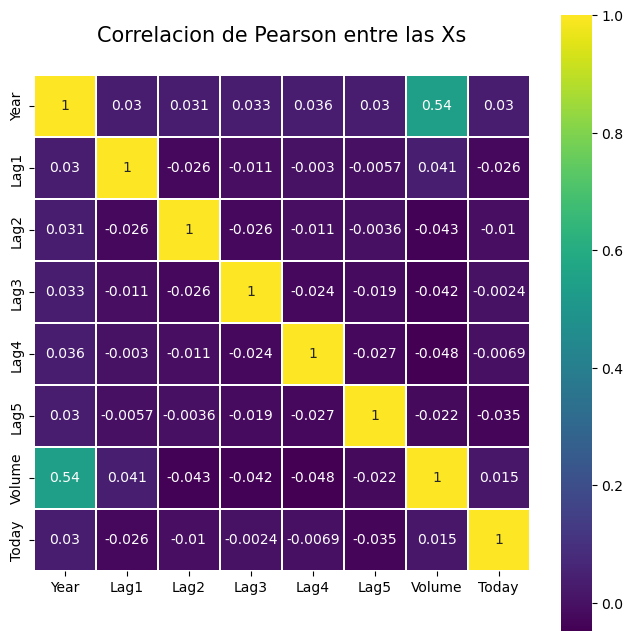

In [25]:
colormap = plt.cm.viridis
plt.figure(figsize=(8,8))
plt.title('Correlacion de Pearson entre las Xs', y=1.05, size=15)
sns.heatmap(smarket.iloc[:,:-1].corr(),
            linewidths=0.1,
            vmax=1.0, 
            square=True, 
            cmap=colormap, 
            linecolor='white', 
            annot=True)


<Axes: >

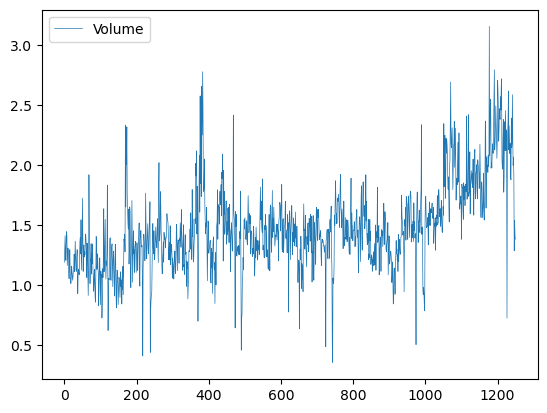

In [50]:
smarket.plot(y='Volume', linewidth=.5)

In [27]:
print(smarket['Direction'].value_counts())

print(smarket.groupby('Direction').mean())

Direction
Up      648
Down    602
Name: count, dtype: int64
                  Year      Lag1      Lag2      Lag3      Lag4      Lag5  \
Direction                                                                  
Down       2002.906977  0.050686  0.032297 -0.005525 -0.003342 -0.000844   
Up         2003.117284 -0.039691 -0.022444  0.008443  0.006261  0.011605   

             Volume     Today  
Direction                      
Down       1.469728 -0.857814  
Up         1.486273  0.802974  


/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_1598/3717475941.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(smarket.groupby('Direction').mean())


Vamos a usar el modelo de **regresión logística** para predicir 'Direction' usando los lags 1 a 5 y Volume. 

In [30]:
y = smarket['Direction']
y = y.replace('Up', 1)
y = y.replace('Down', 0)
 
X = smarket[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
X = sm.add_constant(X)

/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_1598/3439692450.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  y = y.replace('Up', 1)
/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_1598/3439692450.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace('Down', 0)
/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_1598/3439692450.py:3: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that p

### Modelo 1: Logit

In [86]:
logit_model = sm.Logit(y.astype(float),X.astype(float))
result = logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.691034
         Iterations 4
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: Direction        Pseudo R-squared: 0.002    
Date:               2025-05-06 16:37 AIC:              1741.5841
No. Observations:   1250             BIC:              1777.5004
Df Model:           6                Log-Likelihood:   -863.79  
Df Residuals:       1243             LL-Null:          -865.59  
Converged:          1.0000           LLR p-value:      0.73187  
No. Iterations:     4.0000           Scale:            1.0000   
------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
const     -0.1260     0.2407   -0.5234   0.6007   -0.5978   0.3458
Lag1      -0.0731     0.0502   -1.4566   0.1452   -0.1714   0.0253
Lag

El signo negativo del coeficiente Lag1 indicaría que si el mercado ayer tuvo un retorno <font color='gree'>positivo</font> es menos probable que hoy lo tenga. Sin embargo, los pvalores son altos, por los que no hay evidencia de una asociación fuerte entre las variables y el output 

In [100]:
y_new = result.predict(X) 
print(y_new)
# Usamos todos los datos para estimar el modelo. Probabilidad del que índice S&P suba, para cada uno de los días

# Clasificador de Bayes
y_new = np.where(y_new>0.5, 1, y_new)
y_new = np.where(y_new<=0.5, 0, y_new)
print(y_new)

0       0.507084
1       0.481468
2       0.481139
3       0.515222
4       0.510781
          ...   
1245    0.519892
1246    0.505926
1247    0.539268
1248    0.526118
1249    0.517917
Length: 1250, dtype: float64
[1. 0. 0. ... 1. 1. 1.]


### Repaso: Medidas de precisión 

Dependiendo la prioridad del problema seguramente vamos a querer usar diferentes métricas. Scikit learn tiene muchas métricas que pueden explorar en el módulo [metrics](https://scikit-learn.org/stable/modules/model_evaluation.html)

- Sensitivity o Recall o True Positive Rate: TP rate = TP/P
- Specificity o True Negative Rate: 1 - FP rate = TN/N
- False Positive Rate o False Alarm Rate: FP rate = FP/N
- False Negative Rate: FN rate = FN/P
- Precision o Positive Predicted Value: TP/(TP+FP)
- Accuracy: (TP+TN)/(P+N)

Nota: Cuidado con las traducciones! "Accuracy" lo pueden encontrar traducido como "precisión" y eso puede generar confusión con la medida "precision" (o positive predicted value). Mi sugerencia es traducir "accuracy" como "exactitud".


[Matriz de confusión](https://www.unite.ai/what-is-a-confusion-matrix/)
<center>
<img src="https://www.unite.ai/wp-content/uploads/2019/12/Preventive_Medicine-e1576294312614.png" width="1000">

</center>

#### Repaso: Matriz de Confusión
La matriz de confusión de sklearn pone en las filas las Y reales y las columnas las Y predichas. Muestra así los valores:

                               predicción
                         real   tn fp
                                fn tp

In [102]:
conf_mat = confusion_matrix(y, y_new) #Python pone en las filas las Y y en las columnas las Y hat (y predichas)

print('Confusion Matrix:\n', conf_mat) 
print('Accuracy Score:',accuracy_score(y, y_new)) # Cantidad de (vp+vn) sobre total
# Acá, la matriz de confusión tiene en las filas los valores ciertos y en las columnas los valores predichos

Confusion Matrix:
 [[145 457]
 [141 507]]
Accuracy Score: 0.5216


### Curva ROC                  
ROC: Receiver Operating Characteristics

Veremos como utilizar las funciones:

-  [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve): computa la curva de ROC
- [roc_auc_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html#sklearn.metrics.roc_auc_score): Computa el area bajo la curva de ROC de los scores predichos.
- [RocCurveDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.RocCurveDisplay.html#sklearn.metrics.RocCurveDisplay): Sirve para visualizar la curva de ROC. Con el mismo fin existe [plot_roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_roc_curve.html#sklearn.metrics.plot_roc_curve)

In [76]:
# Para graficar la curva ROC lo mejor es usar la funcion LogisticRegression() 
log_reg = LogisticRegression(penalty=None).fit(X.astype(float), y.astype(float))

# Estimacion de los coeficientes
print(log_reg.coef_)

# Predicciones (probabilidad) (p sobrerito)
y_pred_score = log_reg.predict_proba(X)[:,1]   
print(y_pred_score)

[[-0.06308661 -0.07314845 -0.04234797  0.01108602  0.00937296  0.01032962
   0.13553721]]
[0.5070812  0.48142004 0.48108783 ... 0.53928038 0.52612061 0.51791242]


In [78]:
# Computamos la tasa de verdaderos positivos (tpr) y falsos positivos (tpr) para construir la curva ROC
fpr, tpr, thresholds = roc_curve(y, y_pred_score) #If True, always print floating point numbers using fixed point notation, 
#                                     in which case numbers equal to zero in the current precision will print as zero. 

In [68]:
print('Thresholds:', thresholds)   # Estos son los umbrales c en las slides
print('FPR:', fpr)
print('TPR:', tpr)

Thresholds: [       inf 0.64874927 0.63132124 0.62258382 0.61790123 0.61767609
 0.60993653 0.59754439 0.59744853 0.59377351 0.59345508 0.59298714
 0.58616896 0.58153414 0.58147301 0.57963208 0.57774402 0.57513313
 0.57466944 0.574565   0.573605   0.57340864 0.57296543 0.57104103
 0.56843953 0.56685081 0.56646817 0.56518461 0.56503295 0.56463371
 0.56360742 0.56338511 0.56325282 0.56270402 0.56270097 0.56143792
 0.56066993 0.56019517 0.5597215  0.55967353 0.55938413 0.55881926
 0.55874929 0.55869312 0.55850271 0.55842509 0.5582495  0.55812396
 0.55710466 0.55697543 0.55679904 0.55679657 0.5567494  0.55662244
 0.55644602 0.55611344 0.55589112 0.55551757 0.55529998 0.55452972
 0.55439484 0.55433473 0.55423218 0.55414509 0.55357094 0.55345552
 0.55293169 0.5529291  0.5528986  0.55280726 0.55279772 0.55255597
 0.55234376 0.55180388 0.55173492 0.55098568 0.55083486 0.55040648
 0.55035399 0.55016667 0.55009526 0.5496553  0.54960873 0.54927572
 0.54860939 0.54835148 0.54811259 0.54808775 0.548

In [80]:
#Area under curve (es una medida de precisón)
auc = roc_auc_score(y, y_new) 
print('AUC: %.2f' % auc)



AUC: 0.51


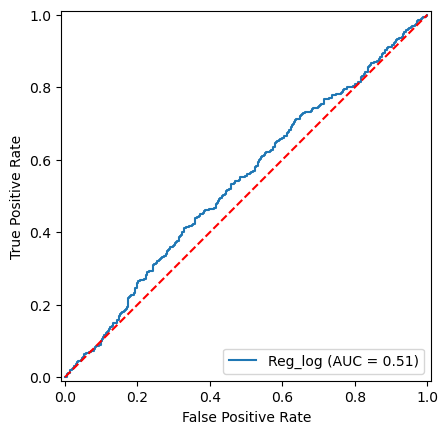

In [82]:
display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=auc, estimator_name='Logit')
display.plot()  
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.show() 

A primera vista, pareciera que la regresión logística funciona apenas mejor que adivinar al azar

In [104]:
# Repetimos pero partiendo la base entre train y test:
train = smarket[smarket.Year < 2005]
test = smarket[smarket.Year >= 2005]
    
ytrain = train['Direction']
ytrain = ytrain.replace('Up', 1)
ytrain = ytrain.replace('Down', 0) 

ytest = test['Direction']
ytest = ytest.replace('Up', 1)
ytest = ytest.replace('Down', 0)

Xtrain = train[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
Xtrain = sm.add_constant(Xtrain) 

Xtest = test[['Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Volume']]
Xtest = sm.add_constant(Xtest)

/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_1598/402738509.py:6: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  ytrain = ytrain.replace('Up', 1)
/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_1598/402738509.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ytrain = ytrain.replace('Down', 0)
/var/folders/s3/z1fnt3zs2nqd6lpnmt4yj7kh0000gn/T/ipykernel_1598/402738509.py:7: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used

### Modelo 2: Logit afuera de la muestra

In [112]:

# Regresión logística
logit_model = sm.Logit(ytrain.astype(float),Xtrain.astype(float))
results = logit_model.fit()
print(results.summary2())

# Probabilidades predichas
y_pred = results.predict(Xtest)
# Predicciones (probabilidad) (p sobrerito)
y_pred_score = log_reg.predict_proba(Xtest)[:,1]   

# Clasificador de Bayes
y_pred=np.where(y_pred>0.5, 1, y_pred)
y_pred=np.where(y_pred<=0.5, 0, y_pred)

# Matriz de confusión
conf_mat = confusion_matrix(ytest, y_pred) 

print('Confusion Matrix:\n', conf_mat) 
print('Accuracy Score:',accuracy_score(ytest, y_pred)) # Cantidad de (vp+vn) sobre total
# Recordar: acá la matriz de confusión tiene en las filas los valores ciertos y en las columnas los valores predichos

Optimization terminated successfully.
         Current function value: 0.691936
         Iterations 4
                         Results: Logit
Model:              Logit            Method:           MLE      
Dependent Variable: Direction        Pseudo R-squared: 0.002    
Date:               2025-05-06 16:45 AIC:              1395.1052
No. Observations:   998              BIC:              1429.4454
Df Model:           6                Log-Likelihood:   -690.55  
Df Residuals:       991              LL-Null:          -691.63  
Converged:          1.0000           LLR p-value:      0.90440  
No. Iterations:     4.0000           Scale:            1.0000   
------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025   0.975]
------------------------------------------------------------------
const      0.1912     0.3337    0.5730   0.5666   -0.4628   0.8452
Lag1      -0.0542     0.0518   -1.0462   0.2955   -0.1557   0.0473
Lag

### Modelo 3: KNN afuera de la muestra

In [116]:
# Vamos a probar con distintos tamaños de k (cantidad de vecinos)
k_range = range(1,10)
scores = {}      # Para guardar la accuracy en un diccionario
scores_list = [] # Para guardar la accuracy en una lista
for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(Xtrain.astype(float), ytrain.astype(float))
        y_pred_knn = knn.predict(Xtest)
        scores[k] = accuracy_score(ytest, y_pred_knn)
        scores_list.append(accuracy_score(ytest, y_pred_knn))

Text(0, 0.5, 'Testing Accuracy')

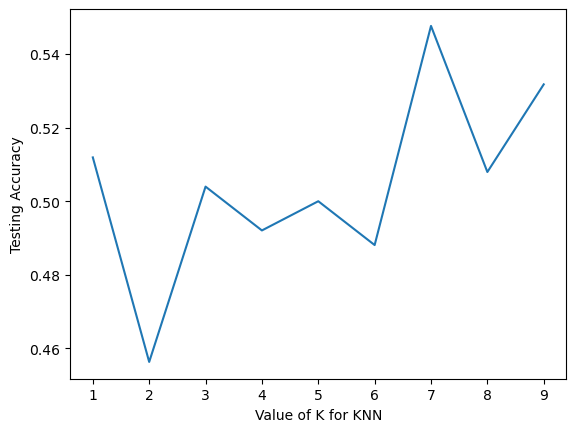

In [118]:
%matplotlib inline
import matplotlib.pyplot as plt

# Graficamos la precisión en base a la cantidad de vecinos
plt.plot(k_range, scores_list)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

Numero optimo de vecinos cercanos es $K=2$

In [121]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(Xtrain.astype(float), ytrain.astype(float))

KNeighborsClassifier(n_neighbors=2)

##### Performance de Vecinos cercanos

In [130]:
y_test_pred_knn = knn.predict(Xtest)
accuracy_knn = accuracy_score(ytest, y_test_pred_knn)
print("La exactitud del modelo es: %.3f" %accuracy_knn)  

# Matriz de confusion
print(pd.crosstab(index=ytest, columns=y_test_pred_knn))

La exactitud del modelo es: 0.456
col_0      0.0  1.0
Direction          
0           75   36
1          101   40


In [138]:
# Tarea para la casa: Hacer la curva ROC para KNN